In [1]:
"""This notebook will serve as a place to produce the lifetime, coalescence time, and delay time distributions of different binary WDs"""

'This notebook will serve as a place to produce the lifetime, coalescence time, and delay time distributions of different binary WDs'

In [1]:
# all of the necessary imports
import h5py as h5  #importing, make sure the kernel is correct or the module will be unknown
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

Here are some functions to run that will be needed for later points in this notebook

In [2]:
# let's now make the definition for the coalescence time (no variations for the very small or very larger eccentiricies)

def tgw(a,e,Mmoremass,Mlessmass):

    # assign units and convert to SI units
    Mmoremass = (Mmoremass * u.Msun).to(u.kg)
    Mlessmass = (Mlessmass * u.Msun).to(u.kg)
    a = (a * u.AU).to(u.m)
    tc = ((((5*((a)**4)*(const.c**5))/(256*(const.G**3)*(Mmoremass)*(Mlessmass)*((Mmoremass)+(Mlessmass))))*(1+(0.27*e**10)+(0.33*e**20)+(0.2*e**1000))*(1-(e**2))**(7/2)))*((3.171e-8)*(u.yr/u.s))*((1e-6)*(u.Myr/u.yr))

    return tc.values

In [3]:
def WD_BINARY_BOOLS(dataframe):

# let's first look at if there are only helium white dwarf WD binaries
    HeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==10,dataframe['Stellar_Type(2)']==10)
# then carbon oxygen WD
    COWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==11,dataframe['Stellar_Type(2)']==11)
# then oxgen neon WD
    ONeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==12,dataframe['Stellar_Type(2)']==12)

# let's look at the combination of WD binaries

# Helium WD combos
    HeCOWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==10,dataframe['Stellar_Type(2)']==11)
    HeONeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==10,dataframe['Stellar_Type(2)']==12)

# Carbon Oxygen WD combos
    COHeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==11,dataframe['Stellar_Type(2)']==10)
    COONeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==11,dataframe['Stellar_Type(2)']==12)

# Oxygen Neon WD combos
    ONeHeWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==12,dataframe['Stellar_Type(2)']==10)
    ONeCOWD_bool = np.logical_and(dataframe['Stellar_Type(1)']==12,dataframe['Stellar_Type(2)']==11)

    # let's return all of these bools
    return(HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool)


Let's try to make a function that can plot these time distributions for us

In [5]:
# let's make a function maybe

def time_distribution(filepath,BSE_key,CE_toggle):

    # let's first read the data in 
    pathToH5_file = filepath #path of the hdf5 file
    Data = h5.File(pathToH5_file)


    # next let's make a pandas dataframe
    SYS_data = pd.DataFrame() # making a pandas dataframe
    for key in Data[BSE_key].keys(): #looping through the "keys" or paramters in BSE_System_Parameters
        SYS_data[key] = Data[BSE_key][key][()] # adding these columns to the dataframe


    # let's make a bool to turn off or on stellar mergers
    BSE_SYS = SYS_data[SYS_data['Merger']==CE_toggle]
    # let's make sure we are only looking at systems where we have double WDs 
    WD_BSE_SYS = BSE_SYS.loc[(BSE_SYS['Stellar_Type(1)']==10)|(BSE_SYS['Stellar_Type(1)']==11)|(BSE_SYS['Stellar_Type(1)']==12)]
    WD_BSE_SYS = WD_BSE_SYS.loc[(WD_BSE_SYS['Stellar_Type(2)']==10)|(WD_BSE_SYS['Stellar_Type(2)']==11)|(WD_BSE_SYS['Stellar_Type(2)']==12)]


    # let's toggle whether star 1 is the donor or star 2 (even though we care more when star 2 is the donor)
    # WD_BSE_SYS_MT = WD_BSE_SYS[WD_BSE_SYS['RLOF(star_number)']==1]


    # let's calculate the delay time of these WD bianries
    # let's gather the semi major axis
    a = np.array(WD_BSE_SYS['SemiMajorAxis>CE'])*(6.96e8) # converting from Rsun to meters

    # the eccentricites
    e = np.array(WD_BSE_SYS['Eccentricity>CE'])

    # masses
    M1 = np.array(WD_BSE_SYS['Mass(1)>CE'])*(1.989e30) # converting from solar masses to kg
    M2 = np.array(WD_BSE_SYS['Mass(2)>CE'])*(1.989e30)


    # let's calculate the coalescence time

    time_gw = [] # this list will be th ecoalescence time of all of the WD binaries

    for seeds in range(WD_BSE_SYS.shape[0]): # looping though all of the binaries

        t_gw = tgw(a[seeds],e[seeds],M1[seeds],M2[seeds])
        time_gw.append(t_gw.value)

    # let's now calculate the delay time
    time = np.array(WD_BSE_SYS['Time'])
    t_col = np.array(time_gw)

    t_delay = [] # this will hold the delay time in Myr

    for binaries in range(WD_BSE_SYS.shape[0]):

        delay = time[binaries] + t_col[binaries] # adding the two values together to get the delay time
        t_delay.append(delay)

    # turning this list into an array
    t_delay = np.array(t_delay)

    # fig,(ax1,ax2,ax3) = plt.subplots(3, 1)
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    log_times = np.log(time)
    ax1.hist(log_times)
    ax1.set_xlabel("Log of Times")

    log_coalescence_times = np.log(t_col)
    ax2.hist(log_coalescence_times[log_coalescence_times<4])
    ax2.set_xlabel("Log of T_Coalescence")
    ax2.set_xlim(0,4) # this is limiting to right above hubble time 10Gyr


    log_delay_times = np.log(t_delay)
    ax3.hist(log_delay_times[log_delay_times<10])
    ax3.set_xlabel("Log of T_delay")


In [ ]:
# make the function so that can change the type of plot it spits out 

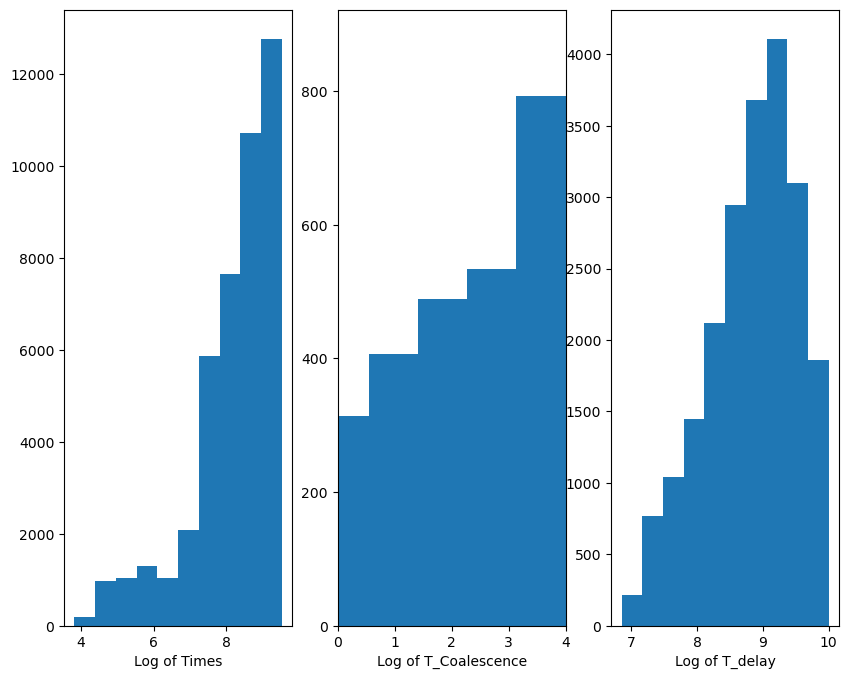

In [7]:
time_distribution('/mnt/home/msantiago/ceph/data/CosmicIntegration/CosmicIntegration/COMPAS_Output_LowMass_1.h5','BSE_Common_Envelopes',False)

We want to see the plots in a little more detail so maybe for now we just go cell by cell rather than making a function

In [4]:
# reading in the HDF5 file
pathToSM_H5 = '/mnt/home/msantiago/ceph/data/CosmicIntegration/CosmicIntegration/COMPAS_Output_LowMass_1.h5' #path of the hdf5 file

Data_2 = h5.File(pathToSM_H5)

In [5]:
# we want to read in the bse_RLOF to get information about thes different systems

CE_SYS_data = pd.DataFrame() # making a pandas dataframe

for key in Data_2["BSE_Common_Envelopes"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    CE_SYS_data[key] = Data_2["BSE_Common_Envelopes"][key][()] # adding these columns to the dataframe

We want to look at the WDWD systems that did not experience a stellar merger but did experience a CE

In [6]:
# CE that ended as double WD and did not experience a SM
CE_WD_SYS = CE_SYS_data.loc[(CE_SYS_data['Stellar_Type(1)']==10)|(CE_SYS_data['Stellar_Type(1)']==11)|(CE_SYS_data['Stellar_Type(1)']==12)]
CE_WD_SYS = CE_WD_SYS.loc[(CE_WD_SYS['Stellar_Type(2)']==10)|(CE_WD_SYS['Stellar_Type(2)']==11)|(CE_WD_SYS['Stellar_Type(2)']==12)]
not_merger_bool = CE_WD_SYS['Merger']==False

CE_WD_SYS = CE_WD_SYS[not_merger_bool] 

In [10]:
pd.set_option('display.max_columns', None) # allows us to see all of the columns
display(CE_WD_SYS)

,BE_Fixed(1),BE_Fixed(2),BE_Kruckow(1),BE_Kruckow(2),BE_Loveridge(1),BE_Loveridge(2),BE_Loveridge_Winds(1),BE_Loveridge_Winds(2),BE_Nanjing(1),BE_Nanjing(2),Binding_Energy<CE(1),Binding_Energy<CE(2),CE_Event_Counter,Double_Core_CE,Eccentricity<CE,Eccentricity>CE,Immediate_RLOF>CE,Lambda@CE(1),Lambda@CE(2),Lambda_Fixed(1),Lambda_Fixed(2),Lambda_Kruckow(1),Lambda_Kruckow(2),Lambda_Loveridge(1),Lambda_Loveridge(2),Lambda_Loveridge_Winds(1),Lambda_Loveridge_Winds(2),Lambda_Nanjing(1),Lambda_Nanjing(2),Luminosity<CE(1),Luminosity<CE(2),MT_History,Mass(1)<CE,Mass(1)>CE,Mass(2)<CE,Mass(2)>CE,Mass_Env(1),Mass_Env(2),Merger,Metallicity@ZAMS(1),Optimistic_CE,RLOF(1),RLOF(2),Radius(1)<CE,Radius(1)>CE,Radius(2)<CE,Radius(2)>CE,Record_Type,RocheLobe(1)<CE,RocheLobe(1)>CE,RocheLobe(2)<CE,RocheLobe(2)>CE,SEED,SemiMajorAxis<CE,SemiMajorAxis>CE,Simultaneous_RLOF,Stellar_Type(1),Stellar_Type(1)<CE,Stellar_Type(2),Stellar_Type(2)<CE,Tau_Circ,Tau_Dynamical<CE(1),Tau_Dynamical<CE(2),Tau_Radial<CE(1),Tau_Radial<CE(2),Tau_Sync,Tau_Thermal<CE(1),Tau_Thermal<CE(2),Teff<CE(1),Teff<CE(2),Time,Zeta_Lobe,Zeta_Star
3,0.0,9.467456e+47,0.0,5.844328e+46,0.0,1.358512e+47,0.0,5.981542e+47,0.0,4.796544e+46,0.0,4.796544e+46,1,0,0.0,0.0,0,1.0,1.973808,0.1,0.1,222.991809,1.619939,0.000000e+00,0.696899,0.000000e+00,0.158278,1.0,1.973808,0.000016,346.773680,4,0.146792,0.146792,1.167450,0.338328,0.0,0.829122,0,0.018059,0,0,1,0.024025,0.024025,38.800908,0.017233,1,15.181586,0.553390,38.467484,0.809453,900010,68.723645,1.788303,0,10,10,10,3,0.0,4.859639e-13,1.118442e-08,-1.0,13.920441,0.0,4.859639e-13,0.002259,2340.105940,4002.839003,10654.693253,15.213935,0.120066
7,0.0,1.920468e+48,0.0,6.853189e+47,0.0,1.452183e+47,0.0,2.375110e+47,0.0,1.752355e+45,0.0,1.752355e+45,1,0,0.0,0.0,0,1.0,109.593522,0.1,0.1,453.954108,0.280230,1.000000e-20,1.322469,1.000000e-20,0.808581,1.0,109.593522,0.029221,26801.784602,4,0.981046,0.981046,5.800472,1.095643,0.0,4.704829,0,0.028932,0,0,1,0.008271,0.008271,539.285303,0.006961,1,240.897745,60.166851,536.450474,63.281807,900023,1002.604984,162.878772,0,11,11,11,6,0.0,3.797375e-14,2.599957e-07,-1.0,0.901680,0.0,3.797375e-14,0.000059,26267.179912,3183.531660,117.945474,9.127954,-0.038279
21,0.0,6.581104e+47,0.0,1.842084e+47,0.0,6.116088e+46,0.0,6.438004e+46,0.0,1.343782e+45,0.0,1.343782e+45,1,0,0.0,0.0,0,1.0,48.974511,0.1,0.1,346.925804,0.357264,1.000000e-20,1.076032,1.000000e-20,1.022227,1.0,48.974511,0.000435,10764.660522,4,0.629964,0.629964,3.008186,0.848545,0.0,2.159641,0,0.002773,0,0,1,0.012380,0.012380,374.632859,0.009757,1,184.019766,56.672387,372.992187,64.931180,900055,721.751656,160.343406,0,11,11,11,5,0.0,8.677899e-14,2.090386e-07,-1.0,0.265134,0.0,8.677899e-14,0.000051,7501.077868,3040.707803,384.223902,6.890506,0.107277
22,0.0,7.889528e+47,0.0,1.917653e+47,0.0,7.591196e+46,0.0,9.375491e+46,0.0,9.143733e+45,0.0,9.143733e+45,1,0,0.0,0.0,0,1.0,8.628345,0.1,0.1,320.432132,0.411416,1.000000e-20,1.039300,1.000000e-20,0.841506,1.0,8.628345,0.000321,9283.673946,4,0.518123,0.518123,2.990011,0.882216,0.0,2.107795,0,0.001594,0,0,1,0.013947,0.013947,303.157557,0.009378,1,136.009475,20.150848,299.671285,25.690147,900056,562.234175,60.349284,0,11,11,11,5,0.0,1.144148e-13,1.526287e-07,-1.0,0.295755,0.0,1.144148e-13,0.000070,6550.549426,3257.416623,424.128965,8.848597,0.128854
40,0.0,3.365151e+46,0.0,5.221429e+45,0.0,6.015607e+44,0.0,1.062957e+45,0.0,6.730302e+46,0.0,6.730302e+46,1,0,0.0,0.0,0,1.0,0.050000,0.1,0.1,293.114834,0.644489,1.000000e-20,5.594034,1.000000e-20,3.165840,1.0,0.050000,0.000077,6244.257727,4,0.400337,0.400337,0.771536,0.593831,0.0,0.177704,0,0.000106,0,0,1,0.015942,0.015942,154.620548,0.012862,1,114.639064,2.259140,154.618475,2.704753,900090,354.057799,6.541695,0,10,10,11,6,0.0,1.590585e-13,1.094442e-07,-1.0,2.530684,0.0,1.590585e-13,0.000004,4291.168208,4130.609489,4699.044827,2.451031,2.174490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Let's calculate the coalescence time for these systems

In [11]:
# Add columns for the more and less massive compact object
CE_WD_SYS['M_moremass'] = CE_WD_SYS[['Mass(1)>CE', 'Mass(2)>CE']].max(axis=1)
CE_WD_SYS['M_lessmass'] = CE_WD_SYS[['Mass(1)>CE', 'Mass(2)>CE']].min(axis=1)

time_gw = tgw((CE_WD_SYS['SemiMajorAxis>CE'].values),(CE_WD_SYS['Eccentricity>CE']),(CE_WD_SYS['M_moremass'].values),(CE_WD_SYS['M_lessmass'].values))

In [12]:
# less effiecnt way as above
# # let's just look at double helium WDs to start, this cell (because of the for loop) takes about 3 mins to run

# let's gather the semi major axis
# a_1 = np.array(CE_WD_SYS['SemiMajorAxis>CE'])*(6.96e8) # converting from Rsun to meters

# # the eccentricites
# e_1 = np.array(CE_WD_SYS['Eccentricity>CE'])

# # masses
# M1_1 = np.array(CE_WD_SYS['Mass(1)>CE'])*(1.989e30) # converting from solar masses to kg
# M2_1 = np.array(CE_WD_SYS['Mass(2)>CE'])*(1.989e30)

# # let's calculate the coalescence time

# time_gw_1 = [] # this list will be th ecoalescence time of all of the WD binaries

# for seeds_1 in range(CE_WD_SYS.shape[0]): # looping though all of the binaries

#     t_gw_1 = tgw(a_1[seeds_1],e_1[seeds_1],M1_1[seeds_1],M2_1[seeds_1])
#     time_gw_1.append(t_gw_1.value)


In [13]:
# let's insert the coalescence time into our dataframe

# only run this cell once per table creation
CE_WD_SYS.insert(70,"Coalescence_Time",time_gw,True)

In [14]:
# let's convert the columns of the data frame into numpy arrays to be able to do operations with them
time_1 = np.array(CE_WD_SYS['Time'])
t_col_1 = np.array(CE_WD_SYS['Coalescence_Time'])

t_delay_1 = [] # this will hold the delay time in Myr

for binaries_1 in range(CE_WD_SYS.shape[0]):

    delay_1 = time_1[binaries_1] + t_col_1[binaries_1] # adding the two values together to get the delay time
    t_delay_1.append(delay_1)


In [15]:
# let's insert the delay time into our dataframe

# only run this cell once per table creation
CE_WD_SYS.insert(71,"Delay_Time",t_delay_1,True)

In [16]:
# let's look at this dataframe
pd.set_option('display.max_columns', None) # allows us to see all of the columns
display(CE_WD_SYS)

,BE_Fixed(1),BE_Fixed(2),BE_Kruckow(1),BE_Kruckow(2),BE_Loveridge(1),BE_Loveridge(2),BE_Loveridge_Winds(1),BE_Loveridge_Winds(2),BE_Nanjing(1),BE_Nanjing(2),Binding_Energy<CE(1),Binding_Energy<CE(2),CE_Event_Counter,Double_Core_CE,Eccentricity<CE,Eccentricity>CE,Immediate_RLOF>CE,Lambda@CE(1),Lambda@CE(2),Lambda_Fixed(1),Lambda_Fixed(2),Lambda_Kruckow(1),Lambda_Kruckow(2),Lambda_Loveridge(1),Lambda_Loveridge(2),Lambda_Loveridge_Winds(1),Lambda_Loveridge_Winds(2),Lambda_Nanjing(1),Lambda_Nanjing(2),Luminosity<CE(1),Luminosity<CE(2),MT_History,Mass(1)<CE,Mass(1)>CE,Mass(2)<CE,Mass(2)>CE,Mass_Env(1),Mass_Env(2),Merger,Metallicity@ZAMS(1),Optimistic_CE,RLOF(1),RLOF(2),Radius(1)<CE,Radius(1)>CE,Radius(2)<CE,Radius(2)>CE,Record_Type,RocheLobe(1)<CE,RocheLobe(1)>CE,RocheLobe(2)<CE,RocheLobe(2)>CE,SEED,SemiMajorAxis<CE,SemiMajorAxis>CE,Simultaneous_RLOF,Stellar_Type(1),Stellar_Type(1)<CE,Stellar_Type(2),Stellar_Type(2)<CE,Tau_Circ,Tau_Dynamical<CE(1),Tau_Dynamical<CE(2),Tau_Radial<CE(1),Tau_Radial<CE(2),Tau_Sync,Tau_Thermal<CE(1),Tau_Thermal<CE(2),Teff<CE(1),Teff<CE(2),Coalescence_Time,Delay_Time,Time,Zeta_Lobe,Zeta_Star,M_moremass,M_lessmass
3,0.0,9.467456e+47,0.0,5.844328e+46,0.0,1.358512e+47,0.0,5.981542e+47,0.0,4.796544e+46,0.0,4.796544e+46,1,0,0.0,0.0,0,1.0,1.973808,0.1,0.1,222.991809,1.619939,0.000000e+00,0.696899,0.000000e+00,0.158278,1.0,1.973808,0.000016,346.773680,4,0.146792,0.146792,1.167450,0.338328,0.0,0.829122,0,0.018059,0,0,1,0.024025,0.024025,38.800908,0.017233,1,15.181586,0.553390,38.467484,0.809453,900010,68.723645,1.788303,0,10,10,10,3,0.0,4.859639e-13,1.118442e-08,-1.0,13.920441,0.0,4.859639e-13,0.002259,2340.105940,4002.839003,1.364178e+14,1.364178e+14,10654.693253,15.213935,0.120066,0.338328,0.146792
7,0.0,1.920468e+48,0.0,6.853189e+47,0.0,1.452183e+47,0.0,2.375110e+47,0.0,1.752355e+45,0.0,1.752355e+45,1,0,0.0,0.0,0,1.0,109.593522,0.1,0.1,453.954108,0.280230,1.000000e-20,1.322469,1.000000e-20,0.808581,1.0,109.593522,0.029221,26801.784602,4,0.981046,0.981046,5.800472,1.095643,0.0,4.704829,0,0.028932,0,0,1,0.008271,0.008271,539.285303,0.006961,1,240.897745,60.166851,536.450474,63.281807,900023,1002.604984,162.878772,0,11,11,11,6,0.0,3.797375e-14,2.599957e-07,-1.0,0.901680,0.0,3.797375e-14,0.000059,26267.179912,3183.531660,1.013270e+20,1.013270e+20,117.945474,9.127954,-0.038279,1.095643,0.981046
21,0.0,6.581104e+47,0.0,1.842084e+47,0.0,6.116088e+46,0.0,6.438004e+46,0.0,1.343782e+45,0.0,1.343782e+45,1,0,0.0,0.0,0,1.0,48.974511,0.1,0.1,346.925804,0.357264,1.000000e-20,1.076032,1.000000e-20,1.022227,1.0,48.974511,0.000435,10764.660522,4,0.629964,0.629964,3.008186,0.848545,0.0,2.159641,0,0.002773,0,0,1,0.012380,0.012380,374.632859,0.009757,1,184.019766,56.672387,372.992187,64.931180,900055,721.751656,160.343406,0,11,11,11,5,0.0,8.677899e-14,2.090386e-07,-1.0,0.265134,0.0,8.677899e-14,0.000051,7501.077868,3040.707803,2.687733e+20,2.687733e+20,384.223902,6.890506,0.107277,0.848545,0.629964
22,0.0,7.889528e+47,0.0,1.917653e+47,0.0,7.591196e+46,0.0,9.375491e+46,0.0,9.143733e+45,0.0,9.143733e+45,1,0,0.0,0.0,0,1.0,8.628345,0.1,0.1,320.432132,0.411416,1.000000e-20,1.039300,1.000000e-20,0.841506,1.0,8.628345,0.000321,9283.673946,4,0.518123,0.518123,2.990011,0.882216,0.0,2.107795,0,0.001594,0,0,1,0.013947,0.013947,303.157557,0.009378,1,136.009475,20.150848,299.671285,25.690147,900056,562.234175,60.349284,0,11,11,11,5,0.0,1.144148e-13,1.526287e-07,-1.0,0.295755,0.0,1.144148e-13,0.000070,6550.549426,3257.416623,6.659534e+18,6.659534e+18,424.128965,8.848597,0.128854,0.882216,0.518123
40,0.0,3.365151e+46,0.0,5.221429e+45,0.0,6.015607e+44,0.0,1.062957e+45,0.0,6.730302e+46,0.0,6.730302e+46,1,0,0.0,0.0,0,1.0,0.050000,0.1,0.1,293.114834,0.644489,1.000000e-20,5.594034,1.000000e-20,3.165840,1.0,0.050000,0.000077,6244.257727,4,0.400337,0.400337,0.771536,0.593831,0.0,0.177704,0,0.000106,0,0,1,0.015942,0.015942,154.620548,0.012862,1,114.639064,2.259140,154.618475,2.704753,900090,354.057799,6.541695,0,10,10,11,6,0.0,1.590585e-13,1.094442e-07,

Now that we have the lifetime, coalescence time, and delay time of these systems, we should find the different bools for the different types of WDs

In [17]:
# let's select the different combinations of the binaries
# let's gatther the different WD binary groups
HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = WD_BINARY_BOOLS(CE_WD_SYS)

# same type WD-WD binaries
HeWD_WD = CE_WD_SYS[HeWD_bool]
COWD_WD = CE_WD_SYS[COWD_bool]
ONeWD_WD = CE_WD_SYS[ONeWD_bool]

# conbinations of the above bianries
He_COMBOS = CE_WD_SYS.loc[HeCOWD_bool|HeONeWD_bool]

CO_COMBOS = CE_WD_SYS.loc[COHeWD_bool|COONeWD_bool]

ONe_COMBOS = CE_WD_SYS.loc[ONeHeWD_bool|ONeCOWD_bool]


#### Coalescence Time Distribution

This first plot is showing the coalescence time distribution of the different types of binary white dwarfs (BWD)

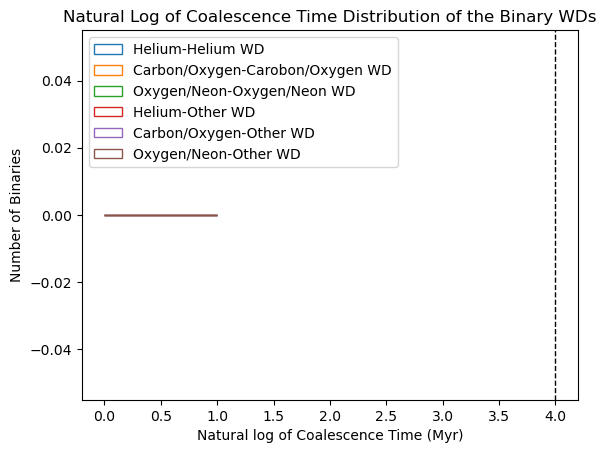

In [22]:
# make sure to specify if you are using ln or log 
# let's also plot the delay time distribution as a histogram to see the distribution another way
He_log_col_times = np.log(HeWD_WD['Coalescence_Time'])
COWD_log_col_times = np.log(COWD_WD['Coalescence_Time'])
ONe_log_col_times = np.log(ONeWD_WD['Coalescence_Time'])
He_COMBOS_log_col_times = np.log(He_COMBOS['Coalescence_Time'])
CO_COMBOS_log_col_times = np.log(CO_COMBOS['Coalescence_Time'])
ONe_COMBOS_log_col_times = np.log(ONe_COMBOS['Coalescence_Time'])


# let's zoom on this plot to just look at the binaires that had delay time below the age of the universe
plt.hist(He_log_col_times[He_log_col_times<4],histtype='step',label='Helium-Helium WD');
plt.hist(COWD_log_col_times[COWD_log_col_times<4],histtype='step',label='Carbon/Oxygen-Carobon/Oxygen WD');
plt.hist(ONe_log_col_times [ONe_log_col_times<4],histtype='step',label='Oxygen/Neon-Oxygen/Neon WD');
plt.hist(He_COMBOS_log_col_times[He_COMBOS_log_col_times<4],histtype='step',label='Helium-Other WD');
plt.hist(CO_COMBOS_log_col_times[CO_COMBOS_log_col_times<4],histtype='step',label='Carbon/Oxygen-Other WD');
plt.hist(ONe_COMBOS_log_col_times[ONe_COMBOS_log_col_times<4],histtype='step',label='Oxygen/Neon-Other WD');

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(4, color='k', linestyle='dashed', linewidth=1)

# changing the y limits to only see things that are less than or equal to hubble time
# plt.xlim(0,age_universe)

plt.xlabel("Natural log of Coalescence Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Coalescence Time Distribution of the Binary WDs")
plt.legend()


This next plot is the coalescence time distribution for low and high metallicities

In [23]:
# let's get the bool for low metallicity (Z0.1*solar metallicity)
z_sol = 0.014
z_low_bool = CE_WD_SYS['Metallicity@ZAMS(1)'] < (0.1*z_sol)
CE_WD_SYS_zlow = CE_WD_SYS[z_low_bool]
#high mettalicity is above this 0.1 criteria
z_high_bool = CE_WD_SYS['Metallicity@ZAMS(1)'] > (0.1*z_sol)
CE_WD_SYS_zhigh = CE_WD_SYS[z_high_bool]

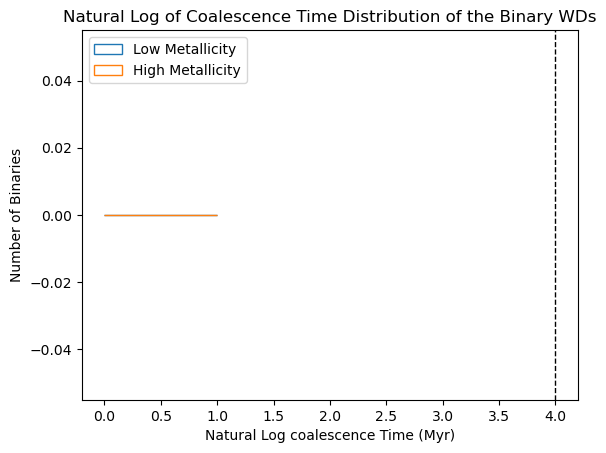

In [24]:
# now let's plot these!

#let's take the log of these times to see the distribution in a more intuitive way
z_low_log_col = np.log(CE_WD_SYS_zlow['Coalescence_Time'])
z_high_log_col = np.log(CE_WD_SYS_zhigh['Coalescence_Time'])

# let's plot the histogram
plt.hist(z_low_log_col[z_low_log_col<4],histtype='step',label='Low Metallicity')
plt.hist(z_high_log_col[z_high_log_col<4],histtype='step',label='High Metallicity')

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(4, color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Natural Log coalescence Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Coalescence Time Distribution of the Binary WDs")
plt.legend()


Let's see if we can make these plots even fancier using scipy.stats.gaussian_kde

In [26]:
# plt.hist(z_low_log_col[z_low_log_col<4],histtype='step',label='Low Metallicity')
# kde_lowz = gaussian_kde(z_low_log_col[z_low_log_col<4], bw_method='silverman')
# x = np.linspace(min(z_low_log_col[z_low_log_col<4]),max(z_low_log_col[z_low_log_col<4]),1000)
# plt.plot(x,kde_lowz(x),color='r',linestyle='-',linewidth=2,label='KDE')

In [20]:
# log_coalescence_times = np.log(CE_WD_SYS['Coalescence Time'])
# plt.hist(log_coalescence_times[log_coalescence_times<4])
# plt.xlabel("Log of T_Coalescence")
# plt.xlim(0,4) # this is limiting to right above hubble time 10Gyr

#### Life Time Distribution 

This is the life time distribution showing the variations of BWDs

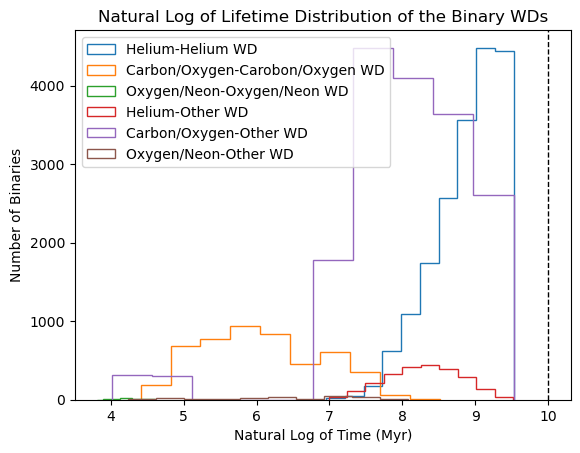

In [28]:
# let's also plot the delay time distribution as a histogram to see the distribution another way
He_log_times = np.log(HeWD_WD['Time'])
COWD_log_times = np.log(COWD_WD['Time'])
ONe_log_times = np.log(ONeWD_WD['Time'])
He_COMBOS_log_times = np.log(He_COMBOS['Time'])
CO_COMBOS_log_times = np.log(CO_COMBOS['Time'])
ONe_COMBOS_log_times = np.log(ONe_COMBOS['Time'])


# let's zoom on this plot to just look at the binaires that had delay time below the age of the universe
plt.hist(He_log_times,histtype='step',label='Helium-Helium WD');
plt.hist(COWD_log_times,histtype='step',label='Carbon/Oxygen-Carobon/Oxygen WD');
plt.hist(ONe_log_times,histtype='step',label='Oxygen/Neon-Oxygen/Neon WD');
plt.hist(He_COMBOS_log_times,histtype='step',label='Helium-Other WD');
plt.hist(CO_COMBOS_log_times,histtype='step',label='Carbon/Oxygen-Other WD');
plt.hist(ONe_COMBOS_log_times,histtype='step',label='Oxygen/Neon-Other WD');

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

# changing the y limits to only see things that are less than or equal to hubble time
# plt.xlim(0,age_universe)

plt.xlabel("Natural Log of Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Lifetime Distribution of the Binary WDs")
plt.legend()

This plot shows the lifetime distribution of the BWDs for high and low metallicities

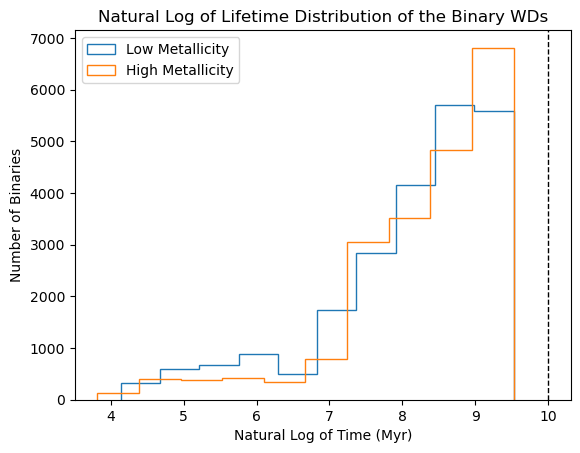

In [29]:
# now let's plot these!

#let's take the log of these times to see the distribution in a more intuitive way
z_low_log_time = np.log(CE_WD_SYS_zlow['Time'])
z_high_log_time = np.log(CE_WD_SYS_zhigh['Time'])

# let's plot the histogram
plt.hist(z_low_log_time,histtype='step',label='Low Metallicity')
plt.hist(z_high_log_time,histtype='step',label='High Metallicity')

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Natural Log of Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Lifetime Distribution of the Binary WDs")
plt.legend()


#### Delay Time Distributions

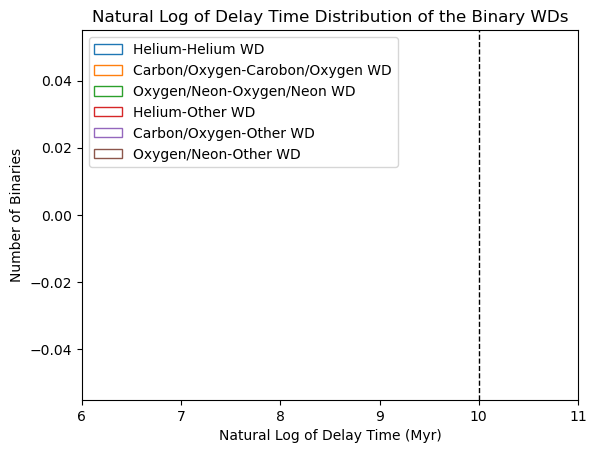

In [36]:
# let's also plot the delay time distribution as a histogram to see the distribution another way
He_log_delay_times = np.log(HeWD_WD['Delay_Time'])
COWD_log_delay_times = np.log(COWD_WD['Delay_Time'])
ONe_log_delay_times = np.log(ONeWD_WD['Delay_Time'])
He_COMBOS_log_delay_times = np.log(He_COMBOS['Delay_Time'])
CO_COMBOS_log_delay_times = np.log(CO_COMBOS['Delay_Time'])
ONe_COMBOS_log_delay_times = np.log(ONe_COMBOS['Delay_Time'])


# let's zoom on this plot to just look at the binaires that had delay time below the age of the universe
plt.hist(He_log_delay_times[He_log_delay_times<10],histtype='step',label='Helium-Helium WD');
plt.hist(COWD_log_delay_times[COWD_log_delay_times<10],histtype='step',label='Carbon/Oxygen-Carobon/Oxygen WD');
plt.hist(ONe_log_delay_times [ONe_log_delay_times<10],histtype='step',label='Oxygen/Neon-Oxygen/Neon WD');
plt.hist(He_COMBOS_log_delay_times[He_COMBOS_log_delay_times<10],histtype='step',label='Helium-Other WD');
plt.hist(CO_COMBOS_log_delay_times[CO_COMBOS_log_delay_times<10],histtype='step',label='Carbon/Oxygen-Other WD');
plt.hist(ONe_COMBOS_log_delay_times[ONe_COMBOS_log_delay_times<10],histtype='step',label='Oxygen/Neon-Other WD');


# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

# changing the y limits to only see things that are less than or equal to hubble time
# plt.xlim(0,age_universe)

plt.xlabel("Natural Log of Delay Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Delay Time Distribution of the Binary WDs")
plt.xlim(6,11)
plt.legend()


Now let's plot the full range of delay times

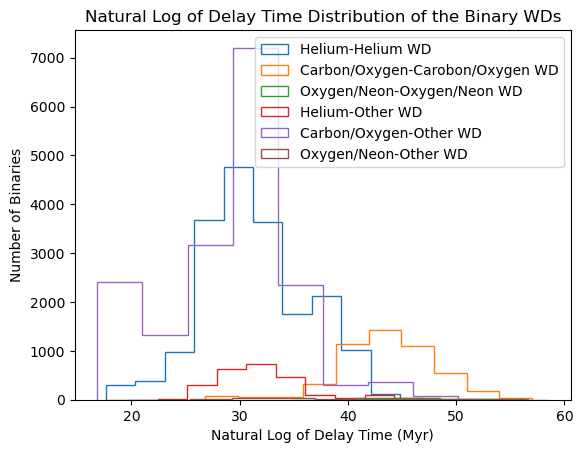

In [33]:
# let's also plot the delay time distribution as a histogram to see the distribution another way
He_log_delay_times = np.log(HeWD_WD['Delay_Time'])
COWD_log_delay_times = np.log(COWD_WD['Delay_Time'])
ONe_log_delay_times = np.log(ONeWD_WD['Delay_Time'])
He_COMBOS_log_delay_times = np.log(He_COMBOS['Delay_Time'])
CO_COMBOS_log_delay_times = np.log(CO_COMBOS['Delay_Time'])
ONe_COMBOS_log_delay_times = np.log(ONe_COMBOS['Delay_Time'])

# let's look at the full range of delay times
plt.hist(He_log_delay_times,histtype='step',label='Helium-Helium WD');
plt.hist(COWD_log_delay_times,histtype='step',label='Carbon/Oxygen-Carobon/Oxygen WD');
plt.hist(ONe_log_delay_times,histtype='step',label='Oxygen/Neon-Oxygen/Neon WD');
plt.hist(He_COMBOS_log_delay_times,histtype='step',label='Helium-Other WD');
plt.hist(CO_COMBOS_log_delay_times,histtype='step',label='Carbon/Oxygen-Other WD');
plt.hist(ONe_COMBOS_log_delay_times,histtype='step',label='Oxygen/Neon-Other WD');

# experimenting with the type of line to plot but still representing the age of the universe
# plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

# changing the y limits to only see things that are less than or equal to hubble time
# plt.xlim(0,age_universe)

plt.xlabel("Natural Log of Delay Time (Myr)")
plt.ylabel("Number of Binaries")
plt.title("Natural Log of Delay Time Distribution of the Binary WDs")
# plt.xlim(6,11)
plt.legend()


This is a plot of the delay time distributions of the BWDs for high and low metallicities

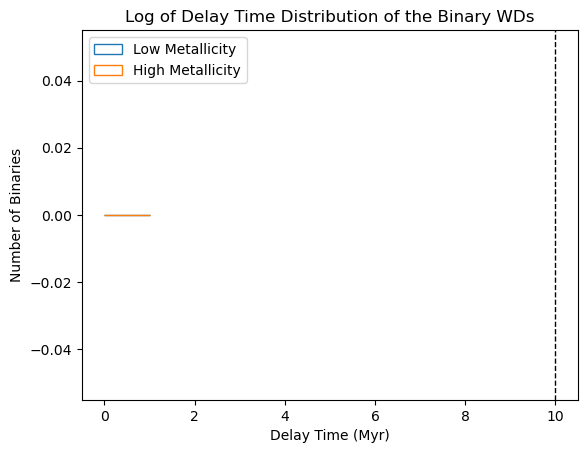

In [34]:
# now let's plot these!

#let's take the log of these times to see the distribution in a more intuitive way
z_low_log_delay = np.log(CE_WD_SYS_zlow['Delay_Time'])
z_high_log_delay = np.log(CE_WD_SYS_zhigh['Delay_Time'])

# let's plot the histogram
plt.hist(z_low_log_delay[z_low_log_delay<10],histtype='step',label='Low Metallicity')
plt.hist(z_high_log_delay[z_high_log_delay<10],histtype='step',label='High Metallicity')

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Natural Log of Delay Time (Myr)")
plt.ylabel("Natural Log of Number of Binaries")
plt.title("Log of Delay Time Distribution of the Binary WDs")
plt.legend()


Let's do thsi distribution but for the full range of delay times

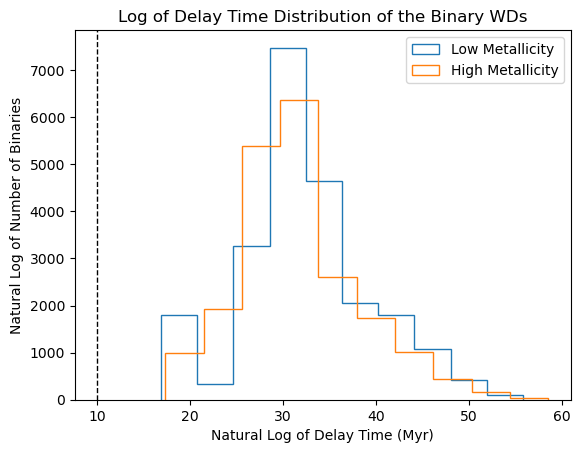

In [35]:
# now let's plot these!

#let's take the log of these times to see the distribution in a more intuitive way
z_low_log_delay = np.log(CE_WD_SYS_zlow['Delay_Time'])
z_high_log_delay = np.log(CE_WD_SYS_zhigh['Delay_Time'])

# let's plot the histogram
plt.hist(z_low_log_delay,histtype='step',label='Low Metallicity')
plt.hist(z_high_log_delay,histtype='step',label='High Metallicity')

# experimenting with the type of line to plot but still representing the age of the universe
plt.axvline(10, color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Natural Log of Delay Time (Myr)")
plt.ylabel("Natural Log of Number of Binaries")
plt.title("Log of Delay Time Distribution of the Binary WDs")
plt.legend()
